### Includes:

In [2]:
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from shap_e.models.testing_utils import test_model
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.fine_tune_data import ShapE_Dataset
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images
# Change it to 0 if you're on one GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Constants

In [2]:
SIMPLE=True
MODEL_PATH="/storage/etaisella/repos/shape_proj/outputs/texturing_7_5_k/model_epoch_19.pt"
DATASET_PATH="/storage/etaisella/repos/shape_proj/data/objaverse_dataset/output_candidate"
PLOT_FOLDER="/storage/etaisella/repos/shape_proj/outputs/texturing_7_5_k/curr_output_candidate"
NUM_CONTROL_LAYERS=24
#CROSS_MODE=True
GUIDANCE_SCALE=7.5
DISPLAY=True # if true, will display the images in the notebook
NUM_VISUAL_EXAMPLES=10
NUM_FRAMES=30
FPS=int(NUM_FRAMES/2)

# rendering options
render_mode = 'nerf' # you can change this to 'nerf'
size = 384 # recommended that you lower resolution when using nerf
cameras = create_pan_cameras(size, device, NUM_FRAMES)
test_cameras = create_pan_cameras(size, device, 1)

def prompt2filename(prompt: str):
    filename = prompt.replace(" ", "_")
    filename = filename.replace("?", "")
    filename = filename.replace("!", "")
    filename = filename.replace(",", "")
    filename = filename.replace('\"', '')
    filename = filename.replace('\\', '')
    filename = filename.replace('/', '')
    return filename

### Setup Dataset

In [45]:
is_shapetalk = "shapetalk" in DATASET_PATH
is_abstract = "abstract" in DATASET_PATH
if is_shapetalk:
    #val_dataset = ShaptalkDataset(DATASET_PATH, 
    #                              only_hard_context="hc" in MODEL_PATH, 
    #                              only_shapenet_mesh="sm" in MODEL_PATH, 
    #                              verbose=True)
    val_dataset = ShaptalkDataset(DATASET_PATH, 
                                  only_hard_context=True,
                                  only_shapenet_mesh=False,
                                  shape_class="table",
                                  split="test",
                                  verbose=True)
elif is_abstract:
    val_dataset = Abstraction_Dataset(DATASET_PATH, 
                                verbose=True)
else:
    val_dataset = ShapE_Dataset(DATASET_PATH, 
                                load_gray=True, 
                                verbose=True)
val_dataloader = DataLoader(
                val_dataset, 
                batch_size = 1,
                shuffle=False, 
                num_workers=0
            )
print("Dataset size: ", len(val_dataset))

dataset length:  1
Dataset size:  1


### Load Model

In [5]:
NUM_CONTROL_LAYERS=24
#CROSS_MODE=True
GUIDANCE_SCALE=7.5
DISPLAY=True # if true, will display the images in the notebook
NUM_VISUAL_EXAMPLES=10
NUM_FRAMES=30

MODEL_PATH="/home/etaisella/repos/SpicyGaussianDreamer/load/spic_e_model_airplane_deabstraction.pt"
xm = load_model('transmitter', device=device)
model = load_model('text300M', device=device)
model.wrapped.backbone.make_ctrl_layers(NUM_CONTROL_LAYERS, 
                                            reverse=False,
                                            cross_mode=True,
                                            conditional=True,
                                            no_one_conv=True)
model.wrapped.set_up_controlnet_cond()
model.load_state_dict(torch.load(MODEL_PATH))
diffusion = diffusion_from_config(load_config('diffusion'))

### Enter Prompt Here:

In [44]:
PROMPT = 'an old lantern'

### Generate Latent

rendering samples for prompt: an old lantern


  0%|          | 0/64 [00:00<?, ?it/s]

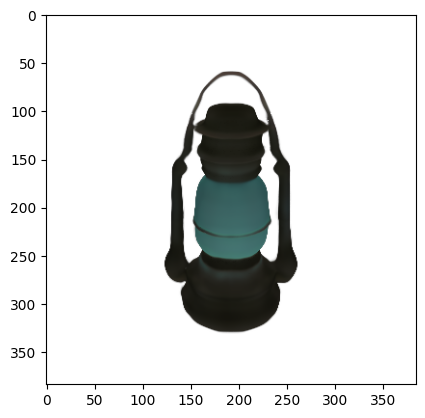

In [50]:
# create output dir if it doesn't exist
os.makedirs(PLOT_FOLDER, exist_ok=True)
if is_shapetalk:
    cond_latent = 'latent_source'
    target_latent = 'latent_target'
elif is_abstract:
    cond_latent = 'latent_abstraction'
    target_latent = 'latent_original'
else:
    cond_latent = 'latent_gray'
    target_latent = 'latent'
num_examples_visualized = 0
with torch.no_grad():
    for sample in val_dataloader:
        if num_examples_visualized >= NUM_VISUAL_EXAMPLES:
            break
        if sample == -1:
            print(f"issue loading validation sample")
            break
        prompt = PROMPT
        filename = prompt2filename(prompt)

        # Rendering Model Output
        print(f"rendering samples for prompt: {prompt}")
        latent = test_model(model=model,
                   diffusion=diffusion, 
                   xm=xm,
                   output_folder=PLOT_FOLDER,
                   cond=sample[cond_latent][0].to(device).detach(),
                   epoch=0, 
                   prompt=prompt,
                   device=device,
                   display=DISPLAY,
                   guidance_scale=GUIDANCE_SCALE,
                   render_mode=render_mode,
                   size=size,
                   return_latents=True,)
        images = decode_latent_images(xm, latent, test_cameras, rendering_mode=render_mode)

        for i, image in enumerate(images):
            if i == 0:
                image.save(os.path.join(PLOT_FOLDER, f'{filename}_target.png'))
                if DISPLAY:
                    plt.imshow(image)
                    plt.show()

        ## Rendering Target Latent
        #print(f"rendering target latent for prompt: {prompt}")
        #images = decode_latent_images(xm, sample[target_latent], cameras, rendering_mode=render_mode)
        #videowriter = cv2.VideoWriter(os.path.join(PLOT_FOLDER, f'{filename}_target.mp4'),
        #                                cv2.VideoWriter_fourcc(*'mp4v'), 10, (size, size))
        #for i, image in enumerate(images):
        #    if i == 0:
        #        image.save(os.path.join(PLOT_FOLDER, f'{filename}_target.png'))
        #        if DISPLAY:
        #            plt.imshow(image)
        #            plt.show()
        #    # convert image to numpy
        #    image = np.array(image)
        #    image = image[:,:,::-1]
        #    videowriter.write(image)
        #videowriter.release()

        ## Rendering Condition Latent
        #print(f"rendering condition latent for prompt: {prompt}")
        #images = decode_latent_images(xm, sample[cond_latent], cameras, rendering_mode=render_mode)
        #videowriter = cv2.VideoWriter(os.path.join(PLOT_FOLDER, f'{filename}_condition.mp4'),
        #                                cv2.VideoWriter_fourcc(*'mp4v'), 10, (size, size))
        #for i, image in enumerate(images):
        #    if i == 0:
        #        image.save(os.path.join(PLOT_FOLDER, f'{filename}_condition.png'))
        #        if DISPLAY:
        #            plt.imshow(image)
        #            plt.show()
        #    # convert image to numpy
        #    image = np.array(image)
        #    image = image[:,:,::-1]
        #    videowriter.write(image)
        #videowriter.release()

        num_examples_visualized += 1

    

    # clear cache
    #del sample
    #torch.cuda.empty_cache()

### Generate Video

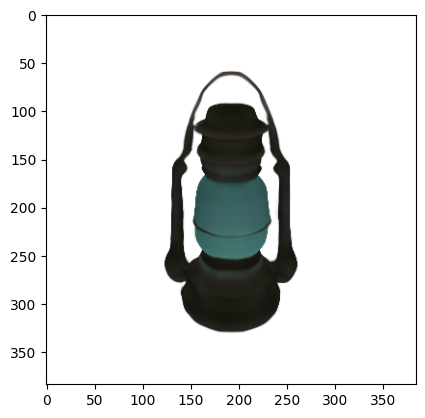

rendering condition latent for prompt: an old lantern


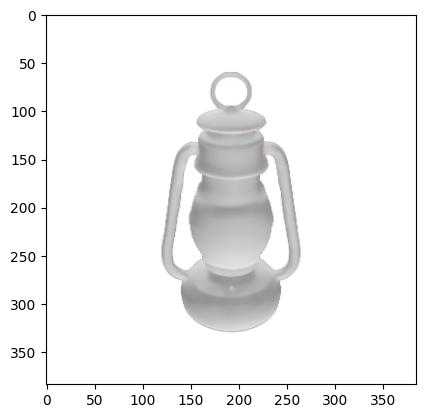

In [51]:
# save latent
torch.save(latent, os.path.join(PLOT_FOLDER, f'{filename}_latent.pt'))

images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
videowriter = cv2.VideoWriter(os.path.join(PLOT_FOLDER, f'{filename}_output.mp4'),
                                cv2.VideoWriter_fourcc(*'mp4v'), FPS, (size, size))
for i, image in enumerate(images):
    if i == 0:
        image.save(os.path.join(PLOT_FOLDER, f'{filename}_target.png'))
        if DISPLAY:
            plt.imshow(image)
            plt.show()
    # convert image to numpy
    image = np.array(image)
    image = image[:,:,::-1]
    videowriter.write(image)
videowriter.release()

# Rendering Condition Latent
print(f"rendering condition latent for prompt: {prompt}")
cond_images = decode_latent_images(xm, sample[cond_latent], cameras, rendering_mode=render_mode)
videowriter = cv2.VideoWriter(os.path.join(PLOT_FOLDER, f'{filename}_condition.mp4'),
                                cv2.VideoWriter_fourcc(*'mp4v'), 10, (size, size))
for i, image in enumerate(cond_images):
    if i == 0:
        image.save(os.path.join(PLOT_FOLDER, f'{filename}_condition.png'))
        if DISPLAY:
            plt.imshow(image)
            plt.show()
    # convert image to numpy
    image = np.array(image)
    image = image[:,:,::-1]
    videowriter.write(image)
videowriter.release()

# create unified video (cond on the right, output on the left)
# create video writer
videowriter = cv2.VideoWriter(os.path.join(PLOT_FOLDER, f'{filename}_unified.mp4'),
                                cv2.VideoWriter_fourcc(*'mp4v'), FPS, (size*2, size))
for i in range(len(images)):
    # convert image to numpy
    image = np.array(images[i])
    image = image[:,:,::-1]
    cond_image = np.array(cond_images[i])
    cond_image = cond_image[:,:,::-1]
    # concatenate images
    image = np.concatenate((cond_image, image), axis=1)
    videowriter.write(image)
videowriter.release()

rendering samples for prompt: a jetblue passenger plane


  0%|          | 0/64 [00:00<?, ?it/s]

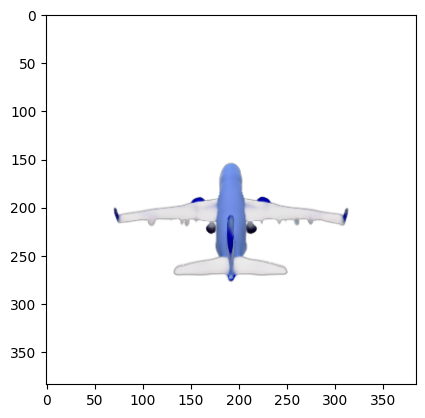

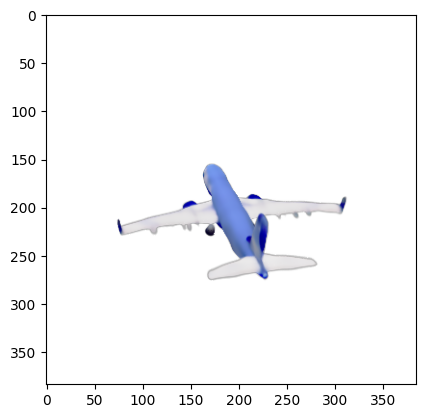

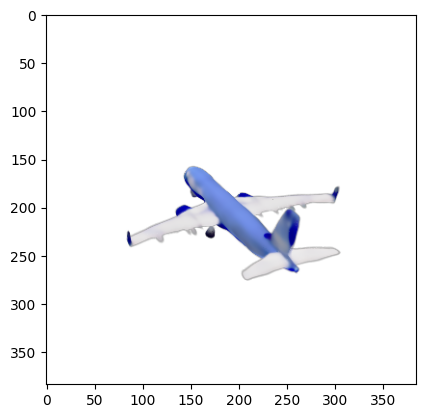

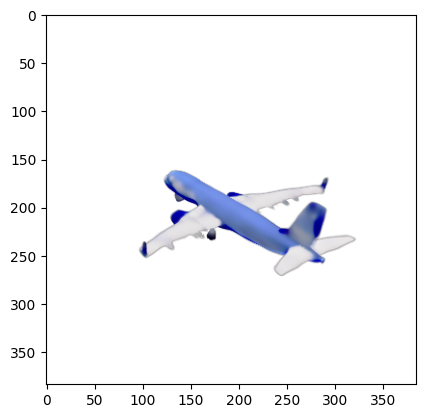

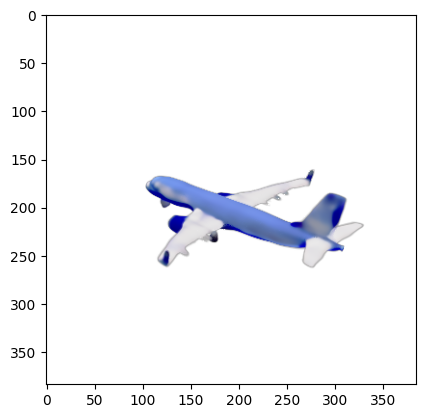

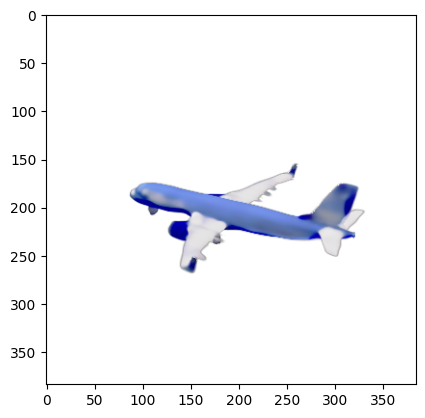

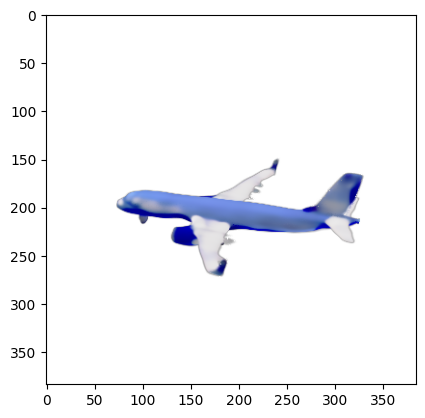

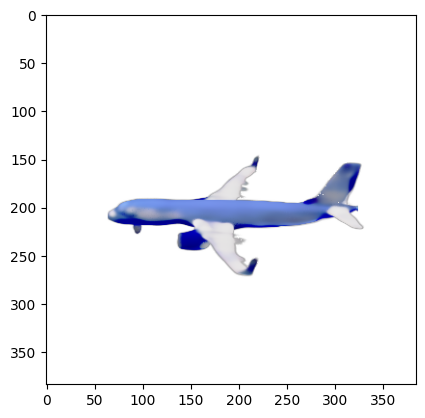

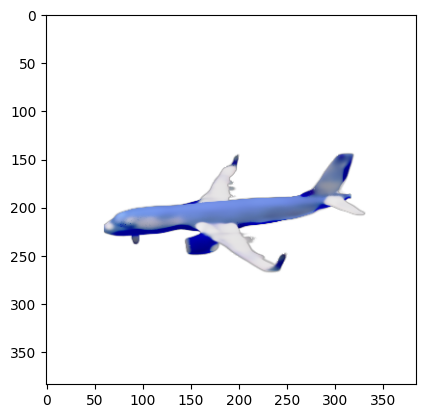

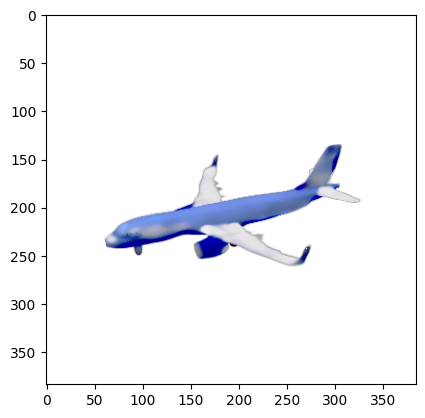

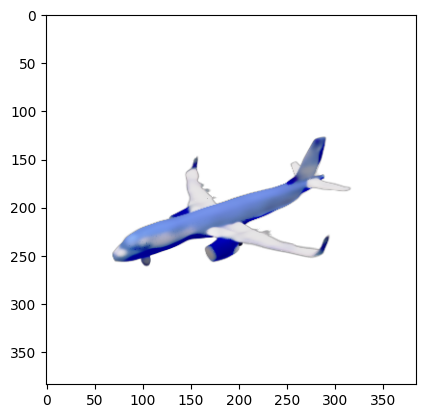

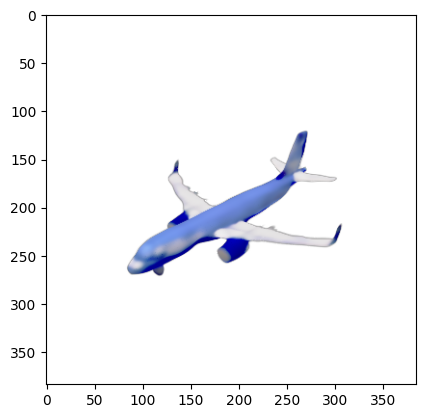

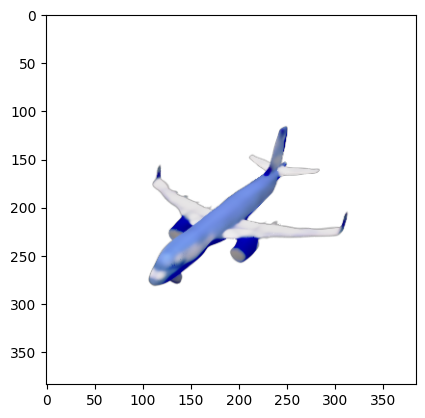

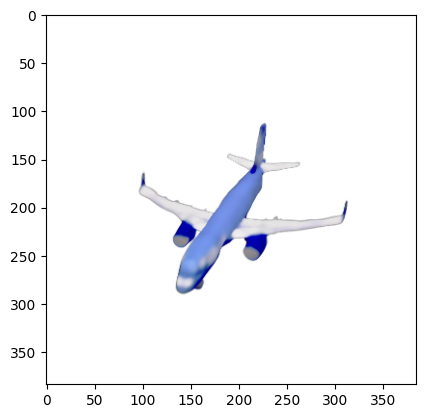

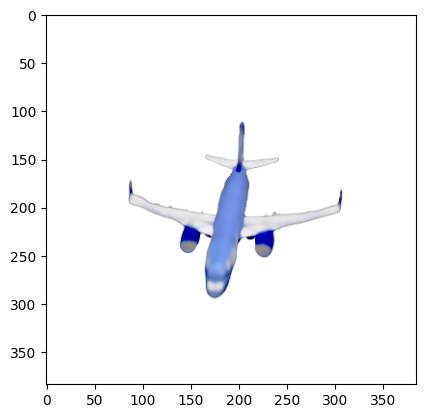

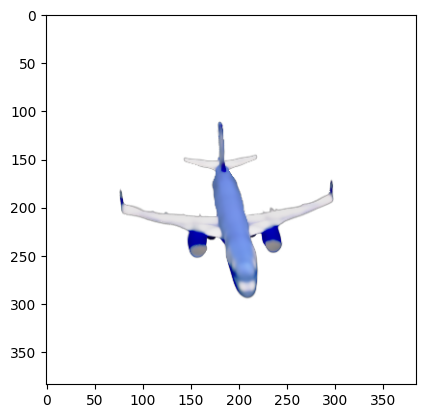

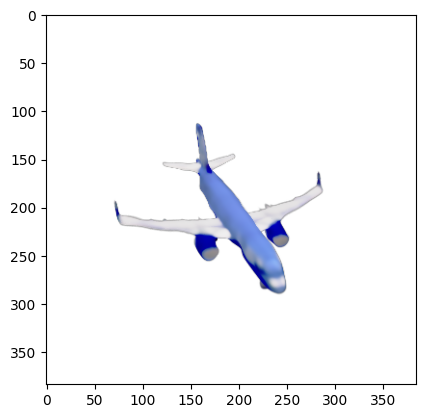

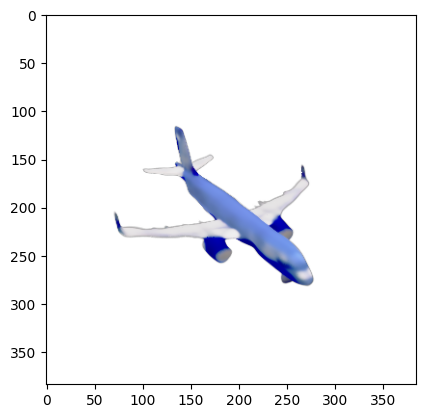

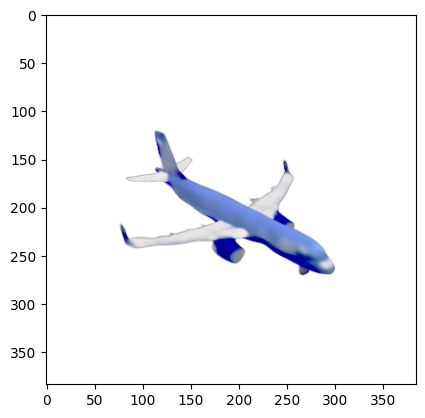

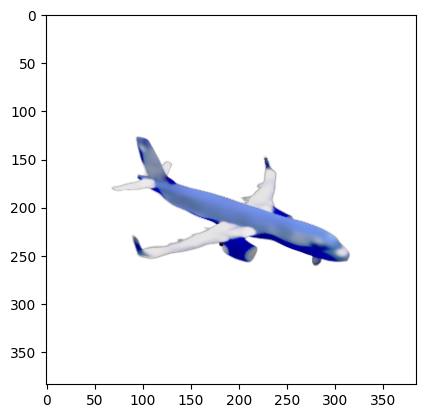

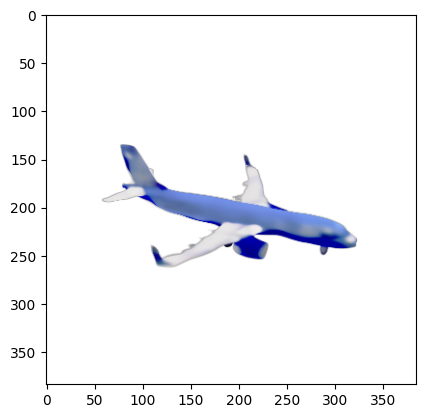

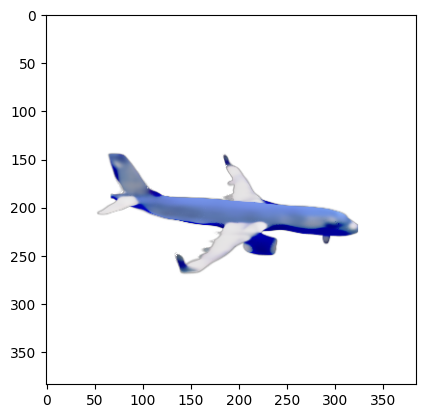

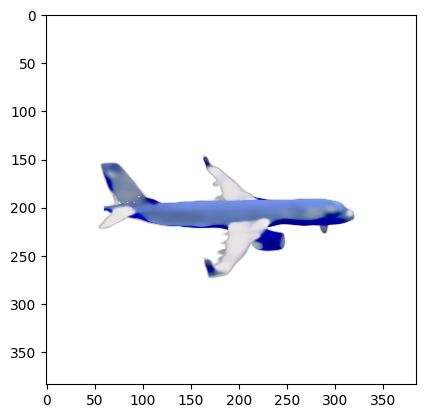

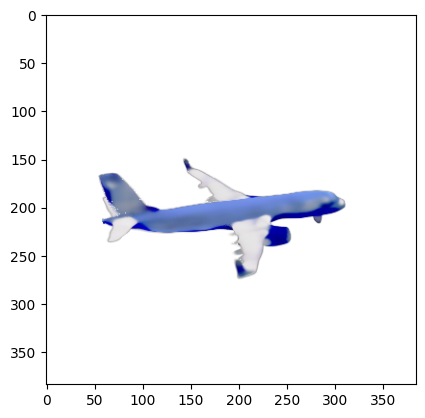

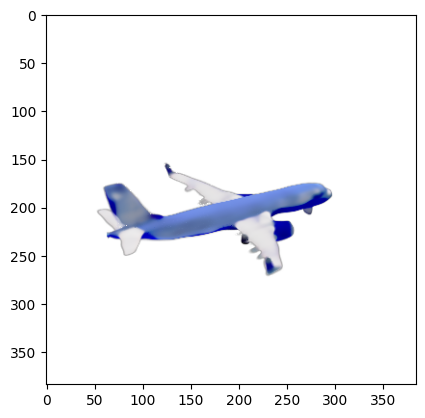

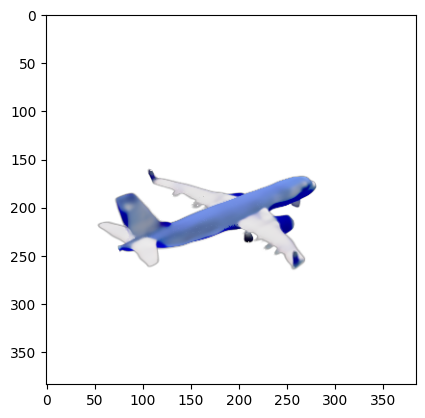

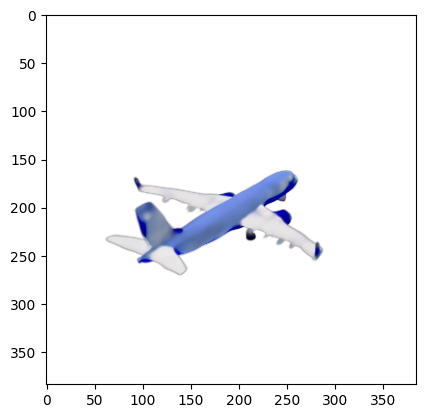

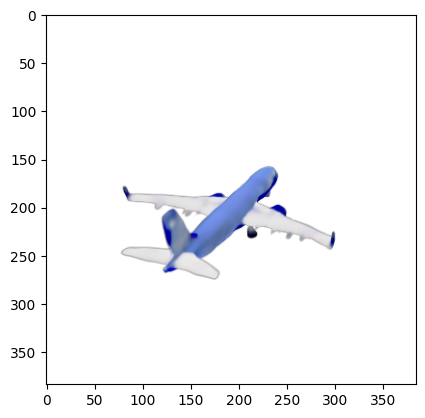

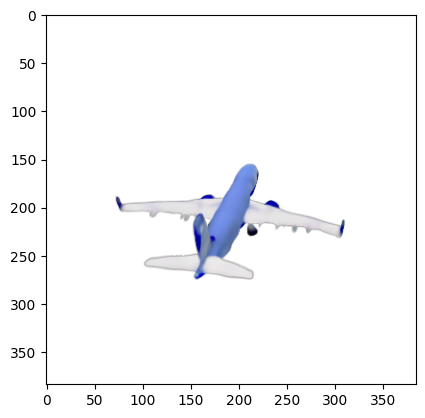

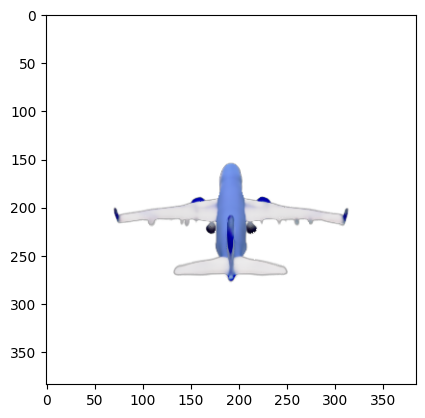

In [14]:
guidance_latent = torch.load(os.path.join("/home/etaisella/repos/SpicyGaussianDreamer/load/airplane_6a242ce20c44e82bcc14f1e6f4f4f49b/latent_abstraction.pt"))
PLOT_FOLDER="/storage/etaisella/repos/shape_proj/outputs/texturing_7_5_k/curr_output_candidate"
test_cameras = create_pan_cameras(384, device, 30)
prompt = "a jetblue passenger plane"

print(f"rendering samples for prompt: {prompt}")
latent = test_model(model=model,
           diffusion=diffusion, 
           xm=xm,
           output_folder="./",
           cond=guidance_latent.to(device).detach(),
           epoch=0, 
           prompt=prompt,
           device=device,
           display=DISPLAY,
           guidance_scale=GUIDANCE_SCALE,
           render_mode='nerf',
           size=384,
           return_latents=True,)
images = decode_latent_images(xm, latent, test_cameras, rendering_mode='nerf')

for i, image in enumerate(images):
    plt.imshow(image)
    plt.show()

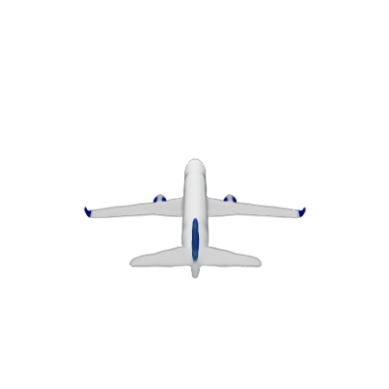

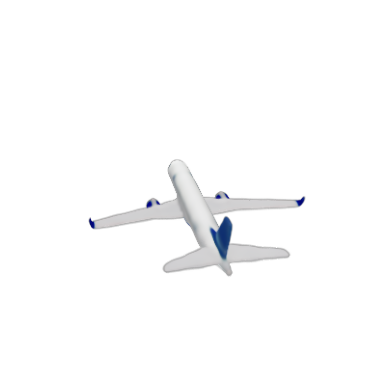

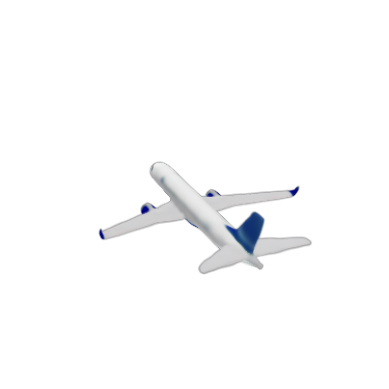

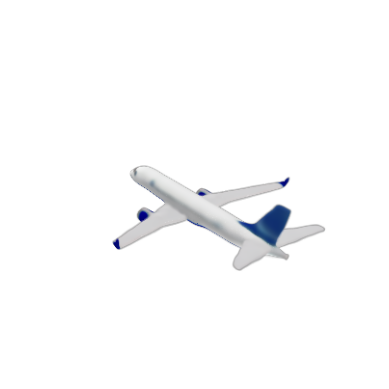

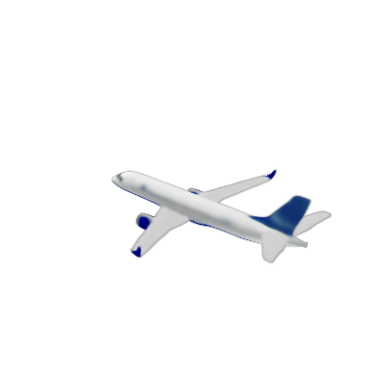

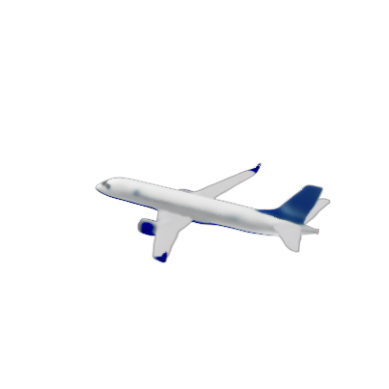

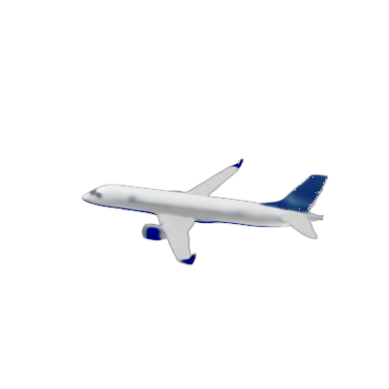

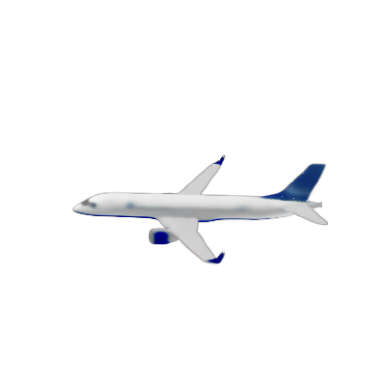

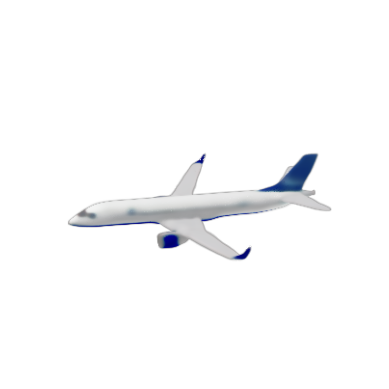

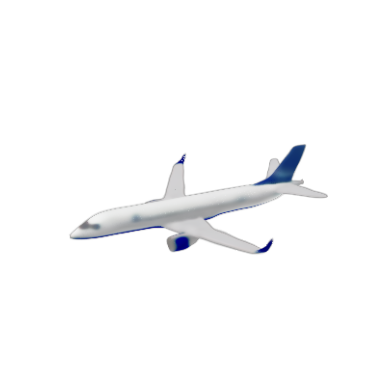

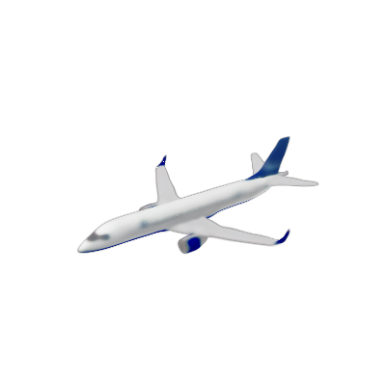

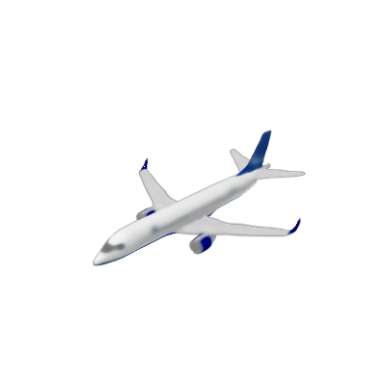

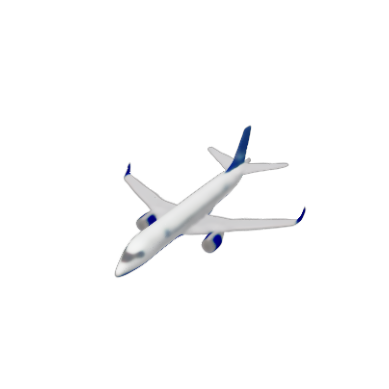

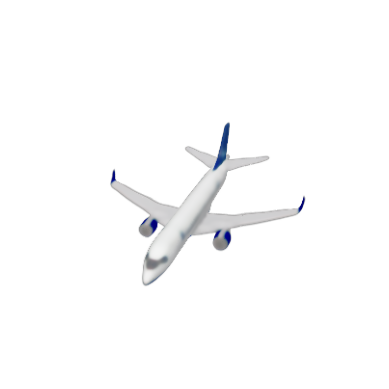

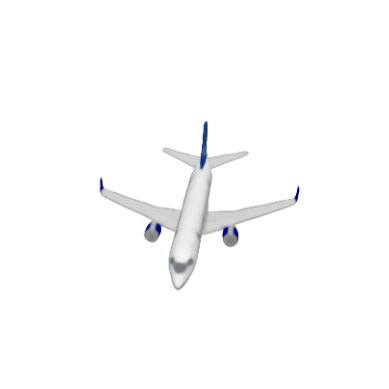

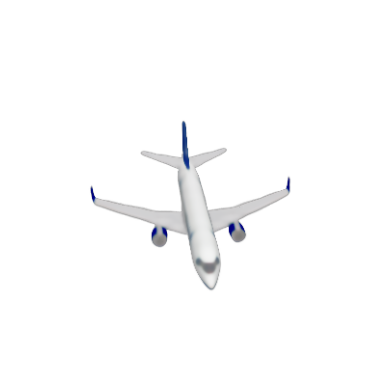

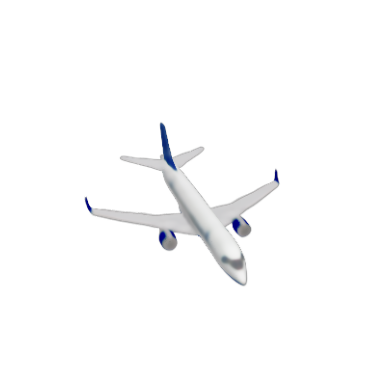

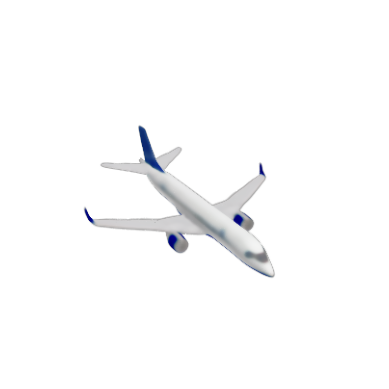

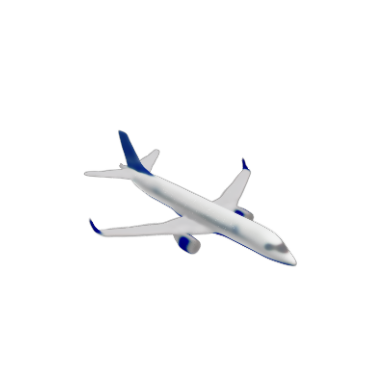

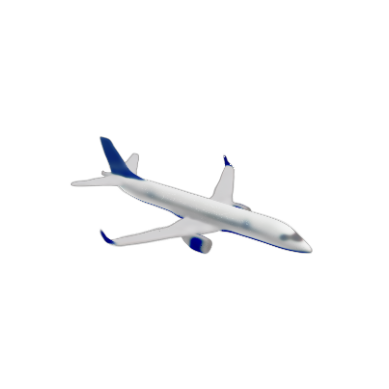

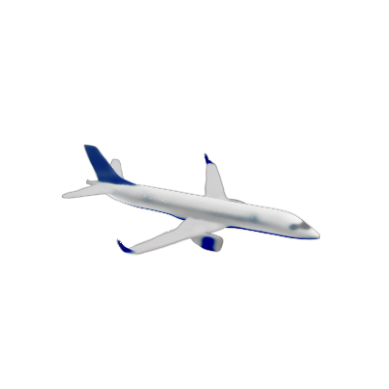

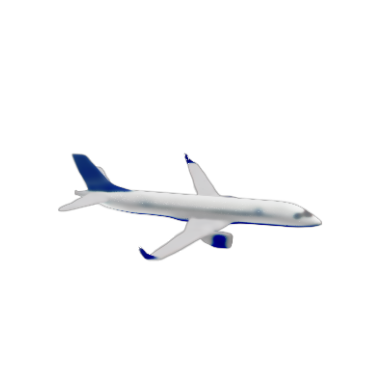

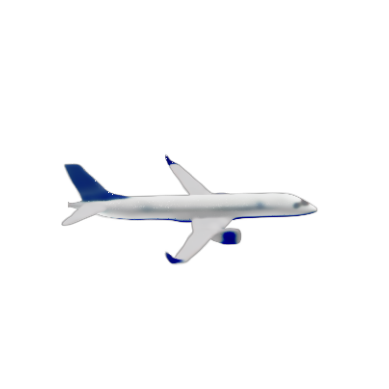

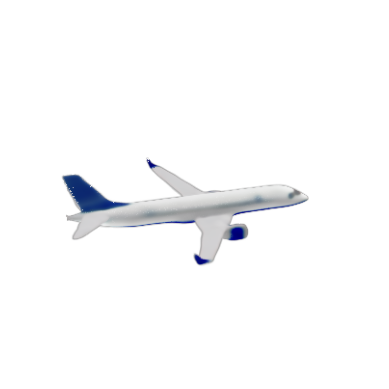

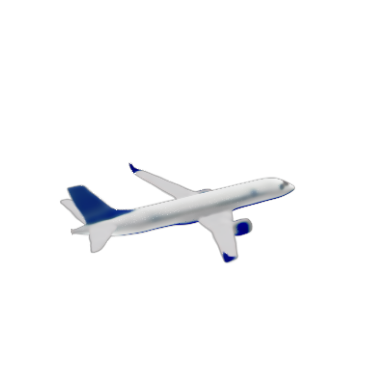

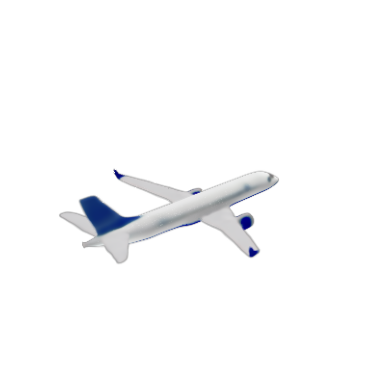

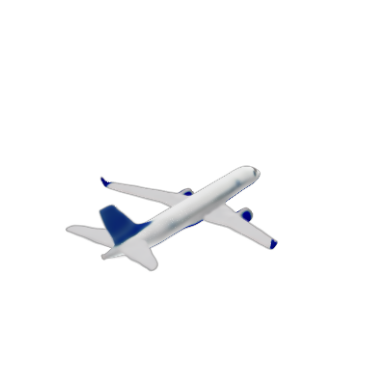

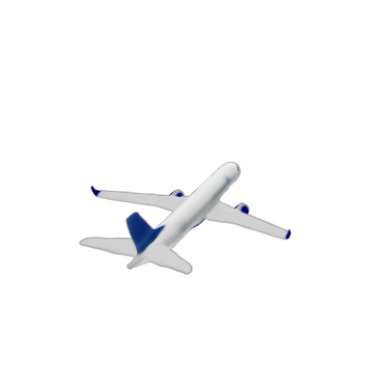

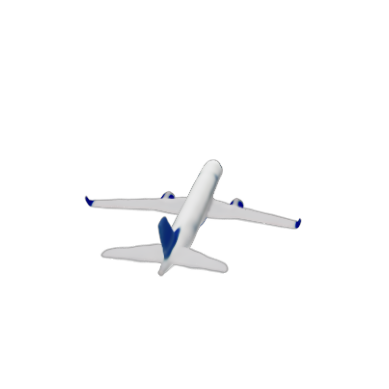

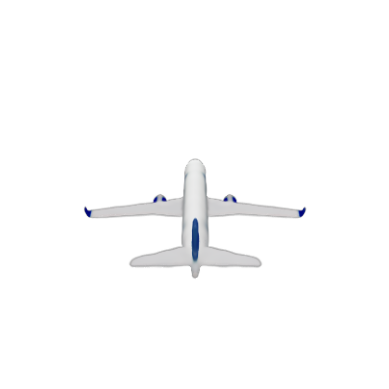

In [17]:
latent = torch.load("/home/etaisella/repos/SpicyGaussianDreamer/load/airplane_6a242ce20c44e82bcc14f1e6f4f4f49b/latent_original.pt")

noise = torch.randn_like(latent)
alpha = 0.1
latent = latent * (1 - alpha) + alpha * noise

images = decode_latent_images(xm, latent, test_cameras, rendering_mode='nerf')

for i, image in enumerate(images):
    # display image with no axis
    plt.imshow(image)
    plt.axis('off')
    plt.show()